In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('data/train.csv')

In [5]:
df.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [6]:
len(df)

5000000

# Format dataloaders

In [8]:
from dataUtils.CustomDataset import IonSwitchingDataset

ion_dataset_train = IonSwitchingDataset('data/train.csv', window_size=100, slice_ratio=0.1)

In [10]:
dataloader = DataLoader(ion_dataset_train, batch_size=10000, shuffle=False, num_workers=1)

In [11]:
batch = next(iter(dataloader))

In [12]:
batch['signal'].shape, batch['open_channels'].shape

(torch.Size([10000, 100]), torch.Size([10000]))

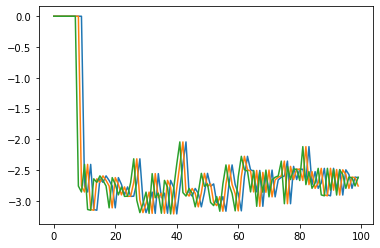

In [15]:
plt.plot(batch['signal'][0])
plt.plot(batch['signal'][1])
plt.plot(batch['signal'][2])
plt.show()